### Observations
- First peak always positive, small amplitude, often has an early shoulder and more noise
- Second peak negative, medium amlitude -> third peak positive, largest amplitude
- Third peak (second positive) used for pressure calibration
- Envelope: 1-2 cycle rise -> exp. decay + low frequency oscillation (f = 18-22Hz)

In [17]:
import audacity as au
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal as sig
import matplotlib.pyplot as pl
%matplotlib notebook

In [18]:
### Instrument specs [SI]
#
# Distance from chimney to open key lip
d_k = 0.00264
# Chimney diameter
d_c = 0.01390
# Bore diameter
d_b = 0.01860
#
### Predefined constants
#
# Pressure calibration slope
pcoeff = 139.47117483232103
# Pressure calibration intercept
pconst = 4.8745979475136032
# Cross section of bore
S = np.pi*(0.5*d_b)**2
# Impedance of bore (rho*c)/S
Z = (1.225*343)/S

In [19]:
def pressureSI(uncalib, pcoeff, pconst):
    p_SI = uncalib*pcoeff+pconst
    return p_SI

In [20]:
def keyclose_analysis(aupfile):
    auf = au.Aup(aupfile)
    w = [ auf.get_channel_data(chno) for chno in range(auf.nchannels) ]
    sr = auf.rate
    w1=w[0]
    w2=w[1]
    ann = auf.get_annotation_data()
    clips = [ w1[int(ann[i]['start']*sr):int(ann[i]['end']*sr)] for i in range(len(ann)) ]
    key = [ w2[int(ann[i]['start']*sr):int(ann[i]['end']*sr)] for i in range(len(ann)) ]
    return clips, key, sr

In [21]:
audio = []
keysig = []
sr = keyclose_analysis('key_only_recordings/calibration/calib_keysig_3.aup')[2]
for n in range(2, 6):
    rec = 'key_only_recordings/calibration/calib_keysig_%d.aup' %n
    audio.extend(keyclose_analysis(rec)[0])
    keysig.extend(keyclose_analysis(rec)[1])

<IPython.core.display.Javascript object>


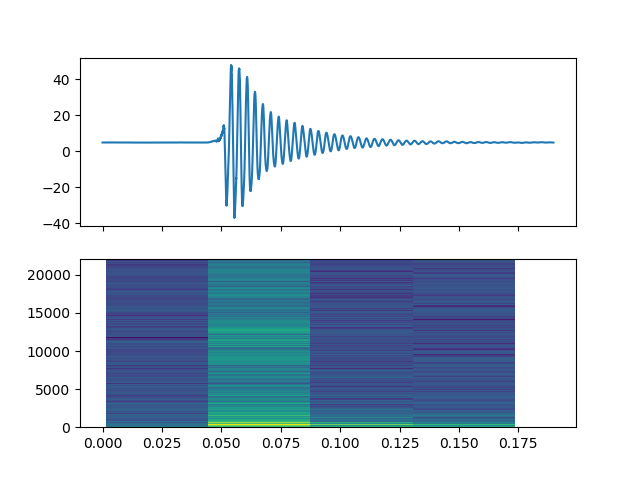

In [24]:
fig,ax = pl.subplots(2, sharex=True)
testaudio = audio[0]
testPA = pressureSI(testaudio, pcoeff, pconst)

ax[0].plot(np.arange(len(testaudio))/sr, testPA)
ax[1].specgram(testaudio, 2024, Fs=sr);

In [7]:
def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [15]:
b, a = sig.butter(4, 250/sr, 'high')
filtaudio = []
for clip in audio:
    filtclip = sig.filtfilt(b, a, clip, padtype='constant')
    filtaudio.extend(filtclip)

rms, t=RMSWind(filtaudio,sr=sr,nwind=360,nhop=80)

In [32]:
# testamp = rms*np.sqrt(2)

# pl.figure()
# pl.plot(np.arange(len(testPA))/sr, testPA)
# # pl.semilogy(np.arange(len(testsig))/sr, testsig)
# maxargs = sig.argrelmax(testPA, order=5)[0]
# maxvals = [ testPA[arg] for arg in maxargs ]
# pl.plot(maxargs/sr, maxvals)

In [13]:
# expfit = np.polyfit(maxargs, np.log(maxvals), 1, w=np.sqrt(maxvals))
# pl.plot(expfit, 'r-')
# would need to resrict region for fitting, slice maxargs

<IPython.core.display.Javascript object>


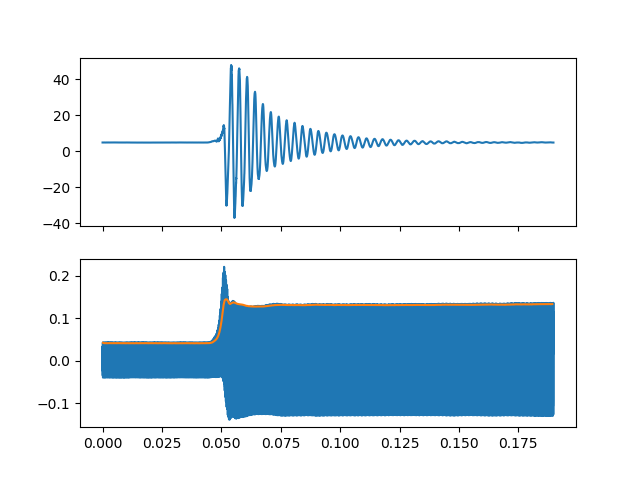

In [39]:
q, p = sig.butter(4, 1000/sr, 'high')
testkeyfilt = sig.filtfilt(q,p,keysig[0], padtype='constant')

keyRMS, t_k=RMSWind(testkeyfilt,sr=sr,nwind=16,nhop=20)
testkey = keyRMS*np.sqrt(2)

fig,ax=pl.subplots(2,sharex=True)
ax[0].plot(np.arange(len(testPA))/sr, testPA)
ax[1].plot(np.arange(len(keysig[0]))/sr, keysig[0])
ax[1].plot(t_k, testkey)

In [14]:
zoom_x = testamp_k[int(0.093*2206):int(0.11*2206)]
zoom_t = t_k[int(0.093*2206):int(0.11*2206)]

<IPython.core.display.Javascript object>


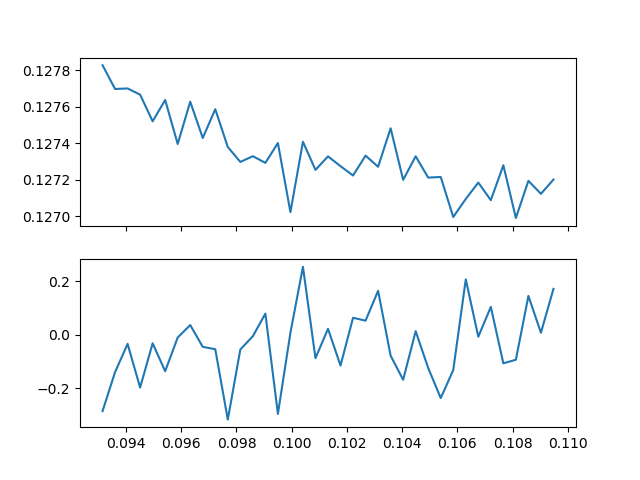

In [15]:
fig, ax=pl.subplots(2, sharex=True)
ax[0].plot(zoom_t, zoom_x)
zoom_v = np.gradient(zoom_x)/np.gradient(zoom_t)
ax[1].plot(zoom_t, zoom_v)

In [18]:
xdiff = np.amax(zoom_x)-np.amin(zoom_x)

In [39]:
d_convert = 0.00264/xdiff
d_convert

NameError: name 'xdiff' is not defined

<IPython.core.display.Javascript object>


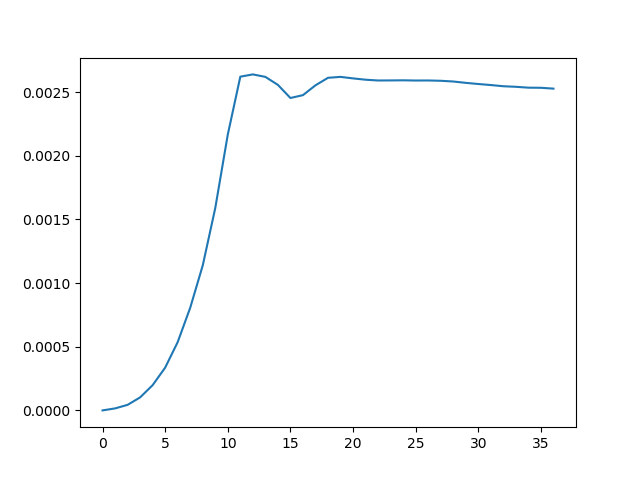

In [20]:
zoom_d = zoom_x*d_convert-np.amin(zoom_x)*d_convert
pl.figure()
pl.plot(zoom_d)

<IPython.core.display.Javascript object>


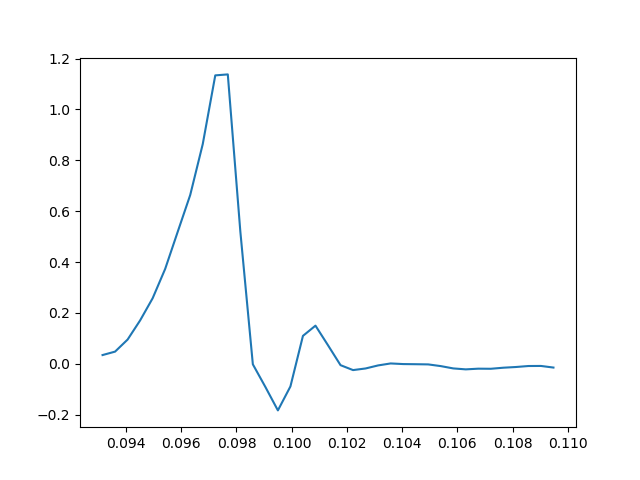

In [21]:
zoom_vSI = np.gradient(zoom_d)/np.gradient(zoom_t)
pl.figure()
pl.plot(zoom_t, zoom_vSI)

In [22]:
max_p = np.amax(testsig)/0.0013967527449131013
max_p

409.22337363838471

<IPython.core.display.Javascript object>


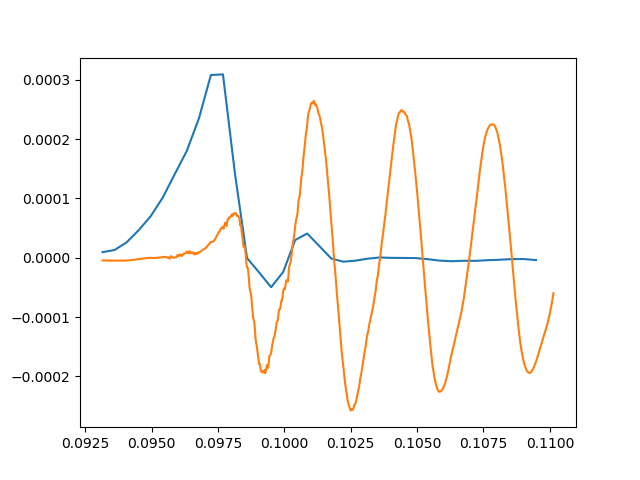

186

In [23]:
Z=1546352.9
S=0.00027172

keyflowsig = zoom_vSI*S
# pflowsig = (rms*np.sqrt(2))[int(0.093*len(t)/len(test_t)):int(0.099*len(t)/len(test_t))]/Z
# pflowsig = maxvals[int(0.093*len(maxvals)/(len(testaudio)/sr)):int(0.099*len(maxvals)/(len(testaudio)/sr))]
pflowsig = (testsig[int(0.093*sr):int(0.11*sr)]/0.0013967527449131013)/Z

# fig, ax=pl.subplots(2, sharex=True)
pl.figure()
pl.plot(zoom_t, keyflowsig)
pl.plot(np.arange(len(pflowsig))/sr+zoom_t[0], pflowsig)
# pl.yscale('log')
len(testamp)

In [77]:
int(0.093*len(maxvals)/(len(testaudio)/sr))

116

In [78]:
len(maxvals)/(len(testaudio)/sr)

1256.0954704292215

In [25]:
sig.filtfilt?

In [ ]:
clips_short = []
for clip in audio:
    

In [33]:
1020/0.145

7034.48275862069